# Dynamic Efficient Case

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate()
using Revise
using Aiyagari
using StructArrays
using ProgressMeter
using DelimitedFiles
using Roots
using Plots
using LaTeXStrings

In [2]:
pgfplotsx();
Threads.nthreads()

8

In [3]:
ProgressMeter.ijulia_behavior(:clear);
default(label = "", lw = 2, dpi = 300, left_margin = 0Plots.mm, format=:svg);

In [4]:
_LOAD_GUESSES = true # load the initial starting guesses for zeros from disk
_SAVE_GUESSES = false # save zeros to disk
_ITERS = 1

# Setting _LOAD_GUESSES to false will recompute all the calculations from scratch. At that point,
# set _ITERS to a higher number.

1

## The benchmark calibration

In [5]:
#' The parameters for technology and households.
e = let
    #Household:
    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1.2)
    sigmaIID = sqrt(0.0522)/(1.2)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    ies = 1.0
    crra = 5.5
    β = 0.993

    hh = Household(u = EZ(ies = ies, ra = crra), grid_points = 5_000,
        v = GHH(θ = 1.0, ν = 0.2), P = P, z_grid = z_vals, β = β, a_max = 10.0)

    #Technology
    δ = 0.1
    μ = 1.4
    α = .3
    #ρ = 0.7
    A_μ = 0.2
    # t_μ = MarkupTechnology(f = CES(α = α, ρ = 0.7), δ = δ, μ = μ, A = A_μ)
    t_μ = MarkupTechnology(f = CobbDouglas(α = α), δ = δ, μ = μ, A = A_μ)

    Economy(h = hh, t = t_μ)
end

Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

In [6]:
# Solve laissez-faire economy
@time laissez_faire = let r_range = (-0.0170, -0.0169)
    solve_laissez_faire(e;
        r_range = r_range,
        tol =  (value_function = 1e-10, distribution = 1e-13)
    )
end

Progress:  19 	 Time: 0:02:07
  r:       -0.016951712036132806
  excess:  -9.696155903737846e-7

141.825408 seconds (1.23 G allocations: 19.371 GiB, 5.88% gc time, 10.85% compilation time)


r=-0.01695171203613281, b=0.0, k=0.5596544425937647, transfer=0.0,  y=0.21689893544099456, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

## Transitions

In [7]:
T = 100  # period of adjustment
H = 50   # stationary part

50

## Transition with constant k and smooth b

We target a debt of 59% percent of output

In [8]:
b_target = laissez_faire.y * 0.60
k_target = laissez_faire.k

0.5596544425937647

In [9]:
@time final_eq_1 = solve_new_stationary_equilibrium_given_k_b(
    laissez_faire,
    k_target,
    b_target;
    r_range = (laissez_faire.r, -0.010),
    tol = (value_function = 1e-10, distribution = 1e-13)
)

Progress:  21 	 Time: 0:06:07
  tr:      0.00012171475512382131
  excess:  1.3787783421648214e-6
  r:       -0.013929982629546426

368.454794 seconds (3.71 G allocations: 55.444 GiB, 6.44% gc time, 0.09% compilation time)


r=-0.013929982629546428, b=0.13013936126459674, k=0.5596544425937647, transfer=0.00012171475512382304,  y=0.21689893544099456, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

In [10]:
# Smooth debt policy
ρB = 0.9
b_list = Array{Float64,1}(undef, T + H)
b_list[1] = 0.0
b_list[2] = laissez_faire.y * 0.05
b_list[T:end] .= b_target
for i in 3:T-1
    b_list[i] = b_list[2] * ρB^(i-2) + (1 - ρB^(i-2)) * b_target
end

In [11]:
# k remains constant
k_list = [laissez_faire.k for _ in b_list];

Computes the transition

In [12]:
r_path = nothing
if _LOAD_GUESSES
    r_path = try
        # load the transfer vector from previous iterations
        readdlm(joinpath(@__DIR__,"..", "output", "tmp_calcs", "tmp_r_001.txt"))
    catch
        nothing
    end
end;

In [13]:
@time transition = solve_transition(
    laissez_faire,
    final_eq_1,
    k_list,
    b_list;
    init_r_path = r_path,
    iterations = _ITERS);

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     1     5.938817e-05              NaN
 16.144152 seconds (25.91 M allocations: 1.468 GiB, 5.41% gc time, 56.49% compilation time)


In [14]:
_SAVE_GUESSES && open(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_r_001.txt"), "w") do io
    writedlm(io, transition.path.r)
end

false

### Plots

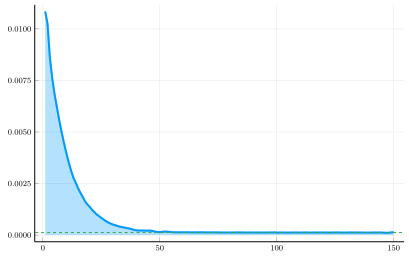

In [15]:
plot(transition.path.transfer, fill = 0, alpha = 0.3,)
plot!(transition.path.transfer, color=1)
hline!([final_eq_1.transfer], lw = 1, style = :dash)

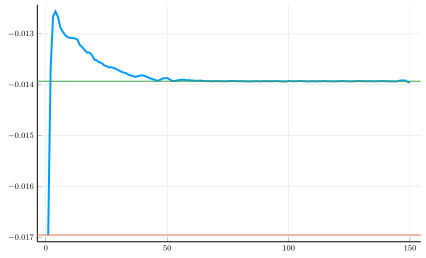

In [16]:
plot(transition.path.r, legend=false)
hline!([laissez_faire.r], lw = 1)
hline!([final_eq_1.r], lw = 1)

## Transition with increasing k and increasing b

We go to the golden rule k -- slowly.

In [17]:
k_golden = golden_rule_k(e.t, laissez_faire.n)
ρK = 0.95
k_list_2 = similar(k_list)
for i in eachindex(k_list_2)
    k_list_2[i] = laissez_faire.k * ρK^(i-1) + (1 - ρK^(i-1)) * k_golden
end

The debt path and its target remains as in the previous case

In [18]:
b_list_2 = b_list
b_target_2 = b_list[end]

0.13013936126459674

Computing the new stationary equilibrium in this case:

In [19]:
@time final_eq_2 = solve_new_stationary_equilibrium_given_k_b(
    laissez_faire,
    k_list_2[end],
    b_target_2;
    r_range = (laissez_faire.r, -0.010),
    tol = (value_function = 1e-10, distribution = 1e-13)
)

Progress:  21 	 Time: 0:06:16
  tr:      0.0008023077981722335
  excess:  1.5832033587459549e-6
  r:       -0.01123812563902465

376.965724 seconds (3.77 G allocations: 56.278 GiB, 6.97% gc time)


r=-0.011238125639024652, b=0.13013936126459674, k=0.6940520913593954, transfer=0.0008023077981722353,  y=0.2313657419711231, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

Computing the transition:

In [20]:
r_path_2 = nothing
if _LOAD_GUESSES
    r_path_2 = try
        # load the transfer vector from previous iterations
        readdlm(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_r_002.txt"))
    catch b
        nothing
    end
end;

In [21]:
@time transition_2 = solve_transition(
    laissez_faire,
    final_eq_2,
    k_list_2,
    b_list_2;
    init_r_path = r_path_2,
    beta = -0.02,
    m = 10,
    iterations = _ITERS
);

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     1     1.133181e-04              NaN
  7.014067 seconds (146.25 k allocations: 181.226 MiB, 0.97% gc time, 1.49% compilation time)


In [22]:
_SAVE_GUESSES && open(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_r_002.txt"), "w") do io
    writedlm(io, transition_2.path.r)
end

false

### Plots

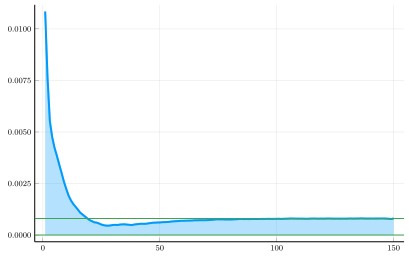

In [23]:
plot(transition_2.path.transfer, fill = 0, alpha = 0.3)
plot!(transition_2.path.transfer, color = 1)
hline!([0, final_eq_2.transfer], lw = 1)

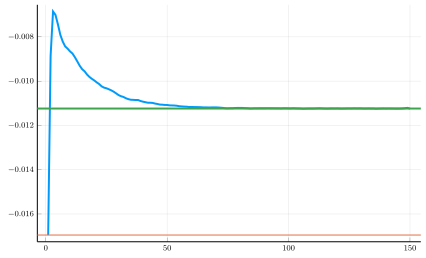

In [24]:
plot(transition_2.path.r, legend=false)
hline!([laissez_faire.r], lw = 1)
hline!([final_eq_2.r])

#### Comparison with previous case

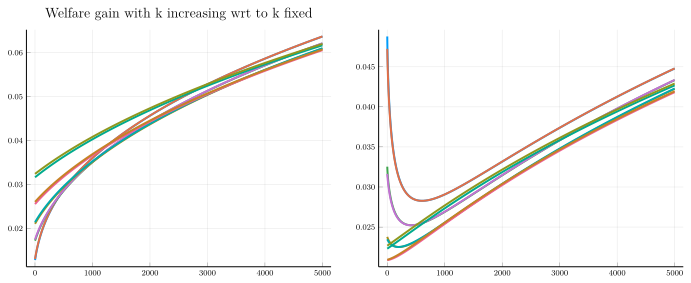

In [25]:
f1 = plot(transition_2.path.v[1] ./ laissez_faire.v .- transition.path.v[1] ./ laissez_faire.v,
    legend = :bottom,
    title = "Welfare gain with k increasing wrt to k fixed")
f2 = plot(transition.path.v[1] ./ laissez_faire.v .- 1)
plot(f1, f2, size = (1000, 400))

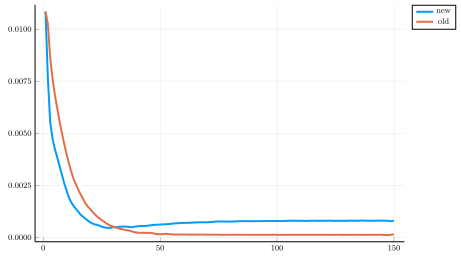

In [26]:
plot(transition_2.path.transfer, label="new")
plot!(transition.path.transfer, label="old")

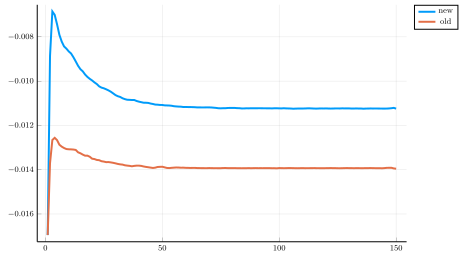

In [27]:
plot(transition_2.path.r, label="new")
plot!(transition.path.r, label="old")

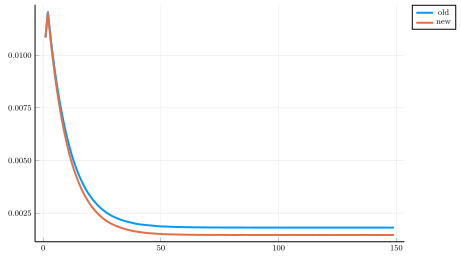

In [28]:
plot(
    [ -(1 + r) * b + bprime for (b, bprime, r) in
        zip(transition.path.b, transition.path.b[2:end], transition.path.r)],
    label = "old"
)
plot!(
    [ -(1 + r) * b + bprime for (b, bprime, r) in
        zip(transition_2.path.b, transition_2.path.b[2:end], transition_2.path.r)],
    label = "new"
)

## Transition with increasing k and no debt

No debt:

In [29]:
b_list_3 = [0.0 for _ in k_list]
b_target_3 = b_list_3[end];

But the same increase in k as before:

In [30]:
k_list_3 = k_list_2;

Computing the new stationary equilibrium

In [31]:
@time final_eq_3 = solve_new_stationary_equilibrium_given_k_b(
    laissez_faire,
    k_list_3[end],
    b_target_3;
    r_range = (laissez_faire.r, -0.010),
    tol = (value_function = 1e-10, distribution = 1e-13)
)

Progress:  21 	 Time: 0:06:00
  tr:      0.0008468566495219588
  excess:  1.0600996699694498e-5
  r:       -0.013409535195433994

360.426074 seconds (3.61 G allocations: 53.908 GiB, 6.69% gc time)


r=-0.013409535195433996, b=0.0, k=0.6940520913593954, transfer=0.0008468566495219605,  y=0.2313657419711231, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=10.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

In [32]:
r_path_3 = nothing
if _LOAD_GUESSES
    r_path_3 = try
        readdlm(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_r_003.txt"))
    catch
        nothing
    end
end;

In [33]:
@time transition_3 = solve_transition(
    laissez_faire,
    final_eq_3,
    k_list_3,
    b_list_3;
    init_r_path = r_path_3,
    beta = -0.02,
    m = 10,
    iterations = _ITERS
);

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     1     9.820587e-05              NaN
  6.810698 seconds (19.16 k allocations: 173.166 MiB)


In [34]:
_SAVE_GUESSES && open(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_r_003.txt"), "w") do io
    writedlm(io, transition_3.path.r)
end

false

### Plots

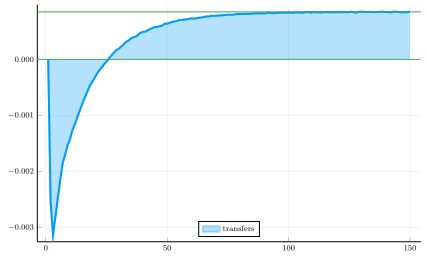

In [35]:
plot(transition_3.path.transfer,
    fill = 0, alpha = 0.3, label = "transfers", legend = :bottom)
plot!(transition_3.path.transfer, color = 1)
hline!([0, final_eq_3.transfer], lw = 1)

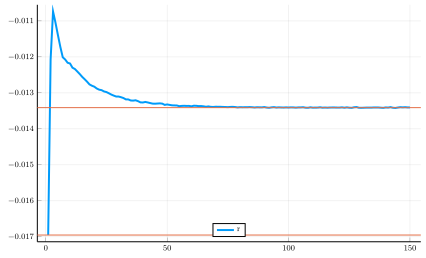

In [36]:
plot(transition_3.path.r, legend = :bottom, label = "r")
hline!([laissez_faire.r, final_eq_3.r], lw = 1)

## Statistics

In [37]:
println("INITIAL STEADY STATE")
println("=====================")
summary_statics(laissez_faire)

INITIAL STEADY STATE

FISCAL
debt: 0.0
debt over y (%): 0.0
transfer over y (%): 0.0
interest rate: -0.01695171203613281

AGGREGATES
capital over y: 2.5802544464125035

HOUSEHOLDS
standard deviation of log c (*100): 68.01167032097642

mass of constrained households (%): 2.6738249927491586
mean wealth (over y): 2.5802499760558906
median wealth (over y): 1.2271349969666152
share of wealth per asset quintiles:
   [0.6161941841301609, 3.843933797356546, 9.75254863763636, 23.09010963729073, 62.697213743584854]


In [38]:
println("\nFINAL STEADY STATE -- CONSTANT K AND DEBT")
println("=====================")
summary_statics(final_eq_1,
    laissez_faire = laissez_faire,
    path = transition.path)


FINAL STEADY STATE -- CONSTANT K AND DEBT

FISCAL
debt: 0.13013936126459674
debt over y (%): 60.0
transfer over y (%): 0.05611588405279862
interest rate: -0.013929982629546428

AGGREGATES
capital over y: 2.5802544464125035

HOUSEHOLDS
standard deviation of log c (*100): 66.09738338390743

mass of constrained households (%): 2.0673043377796887
mean wealth (over y): 3.1802608031903246
median wealth (over y): 1.649987409099061
share of wealth per asset quintiles:
   [0.7684740290190892, 4.244973324789974, 10.531110213292578, 23.482957751674817, 60.97248468122353]

TRANSITION
welfare gain in transition: min = 2.088260595653324,  max = 4.878809494459979,  mean = 2.6285026452507245
mean welfare gain per asset decile:
 [3.57129389592948, 2.8471827980305324, 2.486492514701566, 2.3726974013979634, 2.321784314067289, 2.2738503671477868, 2.269403288901529, 2.3147584026520325, 2.4557239426260145, 2.8224228320566636]


In [39]:
println("FINAL STEADY STATE -- GOLDEN K AND DEBT")
println("=====================")
summary_statics(final_eq_2,
    laissez_faire = laissez_faire,
    path = transition_2.path)

FINAL STEADY STATE -- GOLDEN K AND DEBT

FISCAL
debt: 0.13013936126459674
debt over y (%): 56.24832793129742
transfer over y (%): 0.34677035214330554
interest rate: -0.011238125639024652

AGGREGATES
capital over y: 2.999804921188464

HOUSEHOLDS
standard deviation of log c (*100): 63.87707799504787

mass of constrained households (%): 1.5517744740184576
mean wealth (over y): 3.5622950433613414
median wealth (over y): 1.956031863174891
share of wealth per asset quintiles:
   [0.829410504359482, 4.569659422045951, 11.103845797488335, 23.59575538368539, 59.90132889242084]

TRANSITION
welfare gain in transition: min = 4.484132526417595,  max = 9.216333019522827,  mean = 5.167769669375513
mean welfare gain per asset decile:
 [5.190611144112766, 4.739790048017027, 4.647291958849951, 4.718319748604738, 4.849386411162722, 5.047163617182098, 5.307231861899112, 5.611059150480661, 6.158610144417274, 7.122756070933691]


## Figures for paper

### Transition plots

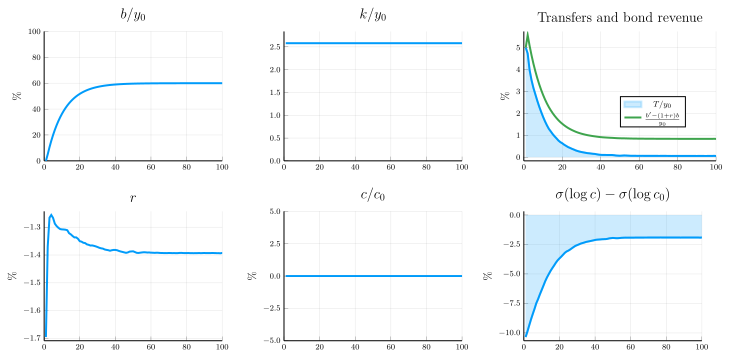

In [40]:
f1 = plot(do_plots(transition, laissez_faire)..., size = (1000, 500))

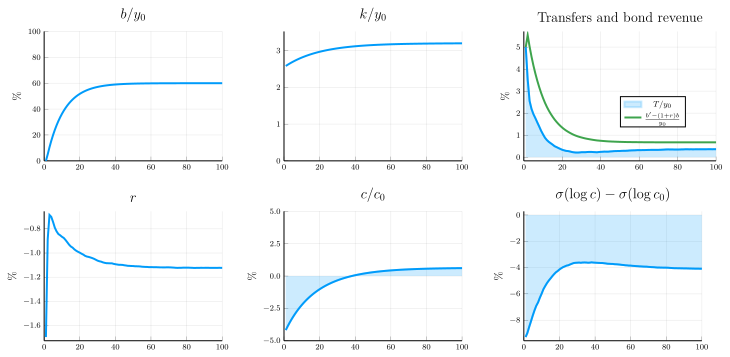

In [41]:
f2 = plot(do_plots(transition_2, laissez_faire)..., size = (1000, 500))

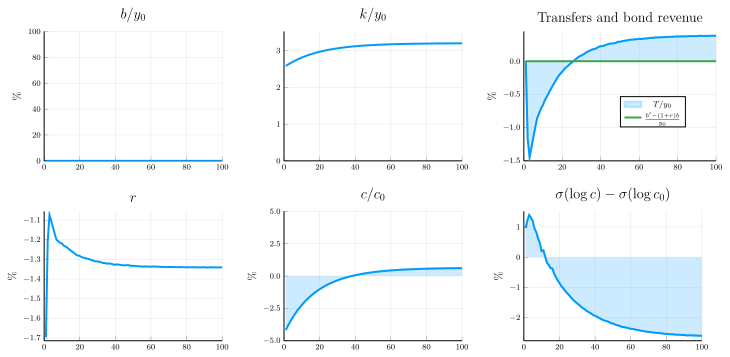

In [42]:
f3 = plot(do_plots(transition_3, laissez_faire)..., size = (1000, 500))

### Steady state segniorage/transfer plot

We need to increase a_max so that it does not bind as we increase b.

In [43]:
# Increasing the amax so that it doesn't bind
e_2 = let
    #Household:
    ar1 = 0.9695
    sigmaP = sqrt(0.0384)/(1.2)
    sigmaIID = sqrt(0.0522)/(1.2)
    P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

    ies = 1.0
    crra = 5.5
    β = 0.993

    hh = Household(u = EZ(ies = ies, ra = crra), grid_points = 5_000,
        v = GHH(θ = 1.0, ν = 0.2), P = P, z_grid = z_vals, β = β, a_max = 50.0)

    #Technology
    δ = 0.1
    μ = 1.4
    α = .3
    #ρ = 0.7
    A_μ = 0.2
    # t_μ = MarkupTechnology(f = CES(α = α, ρ = 0.7), δ = δ, μ = μ, A = A_μ)
    t_μ = MarkupTechnology(f = CobbDouglas(α = α), δ = δ, μ = μ, A = A_μ)

    Economy(h = hh, t = t_μ)
end

Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=50.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

In [44]:
# Solve laissez-faire economy
@time laissez_faire_2 = let r_range = (-0.0175, -0.016)
    solve_laissez_faire(e_2;
        r_range = r_range,
        tol =  (value_function = 1e-10, distribution = 1e-13)
    )
end

Progress:  23 	 Time: 0:03:50
  r:       -0.017104678153991693
  excess:  -0.00014631244083596062

231.333742 seconds (2.27 G allocations: 33.834 GiB, 6.61% gc time)


r=-0.017104678153991696, b=0.0, k=0.5612190268925179, transfer=0.0,  y=0.217104682015008, Economy: EZ(ies = 1.0, ra = 5.5), β=0.993, v=GHH(θ = 1.0, ν = 0.2), z_grid=[0.17222630362336525..3.6217622755477548], P=[..], pts=5000, a_max=50.0, a_min=0.0, CobbDouglas(α=0.3), A=0.2, δ=0.1, μ=1.4, m=0.0, X=0.0

In [45]:
r_guess = nothing
if _LOAD_GUESSES
    r_guess = try
        # load the transfer vector from previous iterations
        readdlm(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_ss_b_r.txt"))
    catch
        nothing
    end
end;

In [46]:
out = let
    range = [laissez_faire_2.r, 0.0]
    f = (b, i) -> begin
        print(i, " ", b, ", ")
        if !isnothing(r_guess)
            myrange = [r_guess[i, 2] - 1e-5, r_guess[i, 2] + 1e-5]
        else
            myrange = range
        end
        sol = solve_new_stationary_equilibrium_given_k_b(
            laissez_faire_2,
            laissez_faire_2.k,
            b * laissez_faire_2.y;
            r_range = myrange,
            tol = (value_function = 1e-7, distribution = 1e-7),
            verbose = false,
            find_zero_args = (xatol = 1e-5, maxevals = _ITERS)
        )
        range[2] = sol.r  # iterating down -- change top value of range
        sol
    end
    [f(i, b) for (b, i) in enumerate(reverse(0.2:0.2:7.0))]
end
push!(out, laissez_faire_2);

1 7.0, 2 6.8, 3 6.6, 4 6.4, 5 6.2, 6 6.0, 7 5.8, 8 5.6, 9 5.4, 10 5.2, 11 5.0, 12 4.8, 13 4.6, 14 4.4, 15 4.2, 16 4.0, 17 3.8, 18 3.6, 19 3.4, 20 3.2, 21 3.0, 22 2.8, 23 2.6, 24 2.4, 25 2.2, 26 2.0, 27 1.8, 28 1.6, 29 1.4, 30 1.2, 31 1.0, 32 0.8, 33 0.6, 34 0.4, 35 0.2, 

In [47]:
_SAVE_GUESSES && open(joinpath(@__DIR__, "..", "output", "tmp_calcs", "tmp_ss_b_r.txt"), "w") do io
    writedlm(io, [(eq.b, eq.r) for eq in out])
end

false

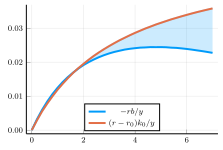

In [48]:
f4 = let
    by = [eq.b / eq.y for eq in out]
    rb = [-eq.r * eq.b / eq.y for eq in out]
    deltark = [(eq.r - laissez_faire_2.r) * eq.k / eq.y for eq in out]
    plot(by, rb,  label = L"- r  b / y", legend = :bottom, size = (1000/3, 500/2))
    plot!(by, deltark, fillrange = rb, color = 1, alpha = 0.2)
    plot!(by, deltark, color = 2, label = L" (r - r_0)  k_0 / y")
end

## Exporting the figures

In [49]:
savefig(f1, joinpath(@__DIR__, "..", "output", "figures", "transition_efficient_fixed_k.pdf"))

In [50]:
savefig(f2, joinpath(@__DIR__, "..", "output", "figures", "transition_efficient_golden_k.pdf"))

In [51]:
savefig(f3, joinpath(@__DIR__, "..", "output", "figures", "transition_efficient_no_debt.pdf"))

In [52]:
savefig(f4, joinpath(@__DIR__, "..", "output", "figures", "steady_state_transfers.pdf"))